In [3]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans

In [4]:
# import dataset
data = pd.read_table('smsdata.txt', header = None)

# rename the column header
data.columns = ["label", "message"]
data.head()

,label,message
0,good,"Go until jurong point, crazy.. Available only ..."
1,good,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,good,U dun say so early hor... U c already then say...
4,good,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# converting labels to numeric labels
# good = 0 and spam = 1
data['label_num']=data.label.map({'good':0,'spam':1})
data.head()

,label,message,label_num
0,good,"Go until jurong point, crazy.. Available only ...",0
1,good,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,good,U dun say so early hor... U c already then say...,0
4,good,"Nah I don't think he goes to usf, he lives aro...",0


In [6]:
# calculating the length of all the messages
data['char_count']=data['message'].apply(len)
data['word_count'] = data['message'].apply(lambda x: len([w for w in x.split(' ')]))

In [7]:
from string import punctuation
punctuations = " ".join(punctuation)
print(punctuations)
data['punctuation_count'] = data['message'].apply(lambda x: len([w for w in x.split() for y in w if y in punctuations]))

! " # $ % & ' ( ) * + , - . / : ; < = > ? @ [ \ ] ^ _ ` { | } ~


In [8]:
data['digit_count'] = data['message'].apply(lambda x: len([w for w in x.split() for y in w if y.isdigit()]))

In [9]:
data['upperchar_count'] = data['message'].apply(lambda x: len([w for w in x.split() for y in w if y.isupper()]))

In [10]:
data.head()

,label,message,label_num,char_count,word_count,punctuation_count,digit_count,upperchar_count
0,good,"Go until jurong point, crazy.. Available only ...",0,111,20,9,0,3
1,good,Ok lar... Joking wif u oni...,0,29,6,6,0,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,28,6,25,10
3,good,U dun say so early hor... U c already then say...,0,49,11,6,0,2
4,good,"Nah I don't think he goes to usf, he lives aro...",0,61,13,2,0,2


In [12]:
# subset clustering variables
cluster=data[['char_count', 'word_count','punctuation_count','digit_count','upperchar_count']]
cluster.describe()

,char_count,word_count,punctuation_count,digit_count,upperchar_count
count,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000
mean,80.457107,15.676238,4.177495,2.384243,5.633345
std,59.938275,11.485406,4.623919,6.253175,11.711637
min,2.000000,1.000000,0.000000,0.000000,0.000000
25%,36.000000,7.000000,2.000000,0.000000,1.000000
50%,61.000000,12.000000,3.000000,0.000000,2.000000
75%,122.000000,23.000000,6.000000,1.000000,4.000000
max,910.000000,171.000000,133.000000,47.000000,138.000000


In [13]:
# standardize clustering variables to have mean=0 and sd=1
clustervar=cluster.copy()
clustervar['char_count']=preprocessing.scale(clustervar['char_count'].astype('float64'))
clustervar['word_count']=preprocessing.scale(clustervar['word_count'].astype('float64'))
clustervar['punctuation_count']=preprocessing.scale(clustervar['punctuation_count'].astype('float64'))
clustervar['digit_count']=preprocessing.scale(clustervar['digit_count'].astype('float64'))
clustervar['upperchar_count']=preprocessing.scale(clustervar['upperchar_count'].astype('float64'))

In [14]:
# split data into train and test sets
clus_train, clus_test = train_test_split(clustervar, test_size=.3, random_state=123)

In [15]:
# k-means cluster analysis for 1-9 clusters                                                           
from scipy.spatial.distance import cdist
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) 
    / clus_train.shape[0])

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

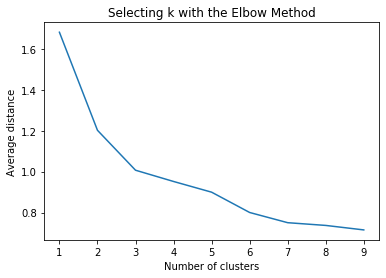

In [16]:
# plot elbow plot
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

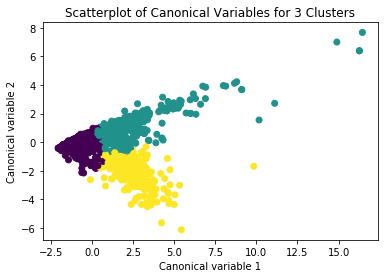

In [17]:
# Interpret 3 cluster solution
model3=KMeans(n_clusters=3)
model3.fit(clus_train)
clusassign=model3.predict(clus_train)
# plot clusters

from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.show()

In [18]:
# create a unique identifier variable from the index for the 
# cluster training data to merge with the cluster assignment variable
clus_train.reset_index(level=0, inplace=True)
# create a list that has the new index variable
cluslist=list(clus_train['index'])
# create a list of cluster assignments
labels=list(model3.labels_)
# combine index variable list with cluster assignment list into a dictionary
newlist=dict(zip(cluslist, labels))
newlist
# convert newlist dictionary to a dataframe
newclus=DataFrame.from_dict(newlist, orient='index')
newclus
# rename the cluster assignment column
newclus.columns = ['cluster']

# now do the same for the cluster assignment variable
# create a unique identifier variable from the index for the 
# cluster assignment dataframe 
# to merge with cluster training data
newclus.reset_index(level=0, inplace=True)
# merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_train=pd.merge(clus_train, newclus, on='index')
merged_train.head(n=100)
# cluster frequencies
merged_train.cluster.value_counts()

0    2656
1     835
2     409
Name: cluster, dtype: int64

In [19]:
# FINALLY calculate clustering variable means by cluster
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)

Clustering variable means by cluster
               index  char_count  word_count  punctuation_count  digit_count  \
cluster                                                                        
0        2777.739081   -0.545741   -0.520059          -0.345067    -0.335375   
1        2780.761677    1.164163    1.217310           0.909643    -0.209319   
2        2749.295844    1.056154    0.780356           0.371444     2.571382   

         upperchar_count  
cluster                   
0              -0.302770  
1               0.124475  
2               1.458769  
